In [1]:
# !pip install tensorflow tensorflow-io matplotlib librosa

In [2]:
# !pip install sounddevice

In [3]:
using_colab = False
if 'google.colab' in str(get_ipython()):
    using_colab = True
print('Using Colab:', using_colab)

Using Colab: True


In [4]:
if(using_colab):
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import librosa

from IPython.display import Audio

In [6]:
if using_colab:
    ROOT = "/content/drive/MyDrive/Collabs/speaker-recognition/"
else:
    ROOT = "./"

NETANYAU = f"{ROOT}16000_pcm_speeches/Benjamin_Netanyau"
MANDELA = f"{ROOT}16000_pcm_speeches/Nelson_Mandela"
BACKGROUND_NOISE = f"{ROOT}16000_pcm_speeches/_background_noise_"
EMMANUEL = f"{ROOT}16000_pcm_speeches/Emmanuel_Fernandez"

ROOT_FOLDER_DIR = f"{ROOT}16000_pcm_speeches/"

sample_rate = 16000;

In [7]:
# def load_wav_16k_mono(filename):
#     # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
#     # Decode wav (tensors by channels)
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav

In [8]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    # sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav_np = tf.cast(wav, tf.float32).numpy()

    wav_resampled = librosa.resample(y=wav_np, orig_sr=sample_rate.numpy(), target_sr=16000)

    # Convert back to TensorFlow tensor
    wav_resampled = tf.convert_to_tensor(wav_resampled, dtype=tf.float32)

    return wav_resampled

In [ ]:
wave = load_wav_16k_mono(EMMANUEL + '/06f76df8-63b7-4c04-a704-e3e0a626bfc5-byVC.wav')
Audio(wave, rate=16000)

In [ ]:
def filter_silent_parts(wave):
  newWave = [];
  res = librosa.effects.split(y=wave, frame_length=8000, top_db=30);

  #check if .numpy exists on wave
  if hasattr(wave, 'numpy'):
    wave = wave.numpy();

  for inter in res:
    newWave += wave[inter[0]:inter[1]].tolist();

  return newWave;



In [ ]:
newWave = filter_silent_parts(wave);
Audio(newWave, rate=16000);


In [ ]:
def split_into_1sec_pieces(wave, piece_size):

  end = (len(wave) // piece_size)*piece_size
  audio_pieces = [wave[i:i+piece_size] for i in range(0, end, piece_size)]
  return audio_pieces;

In [ ]:
audio_pieces = split_into_1sec_pieces(newWave,16000)


In [ ]:
Audio(newWave,rate=16000)

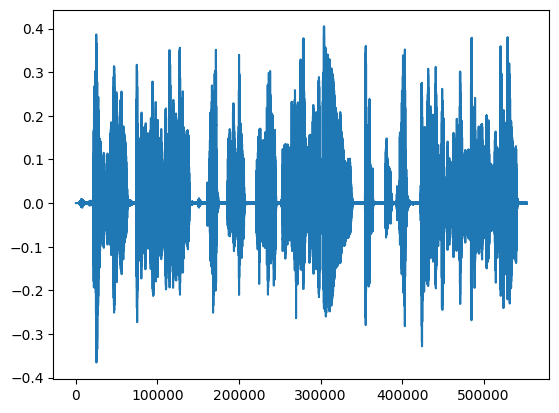

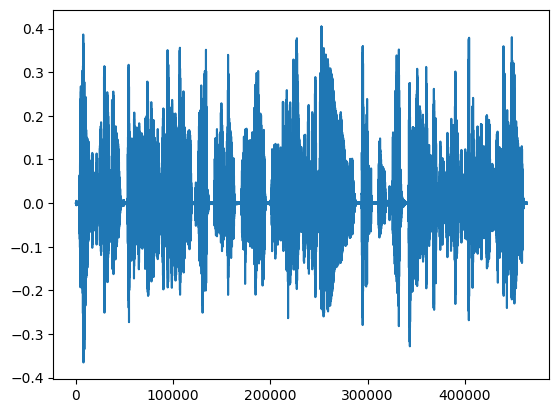

In [ ]:

plt.plot(wave)
plt.show()
plt.plot(newWave)
plt.show()

In [ ]:
def generate_spectrogram(wave):
  spectrogram = tf.signal.stft(wave, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)

  return spectrogram

In [ ]:

def generate_mel_spectrogram(audio, sample_rate):
    # Compute the mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    # Convert to log scale (dB)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    log_spectrogram = np.expand_dims(log_spectrogram, axis=2);
    return log_spectrogram


def disp_mel_spectrogram(mel_spectrogram):
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(np.squeeze(mel_spectrogram, axis=2), sr=sample_rate, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.tight_layout()
  plt.show()

In [ ]:
Audio(audio_pieces[0], rate=16000)
spect = generate_spectrogram(audio_pieces[0])
spect.shape


TensorShape([491, 257, 1])

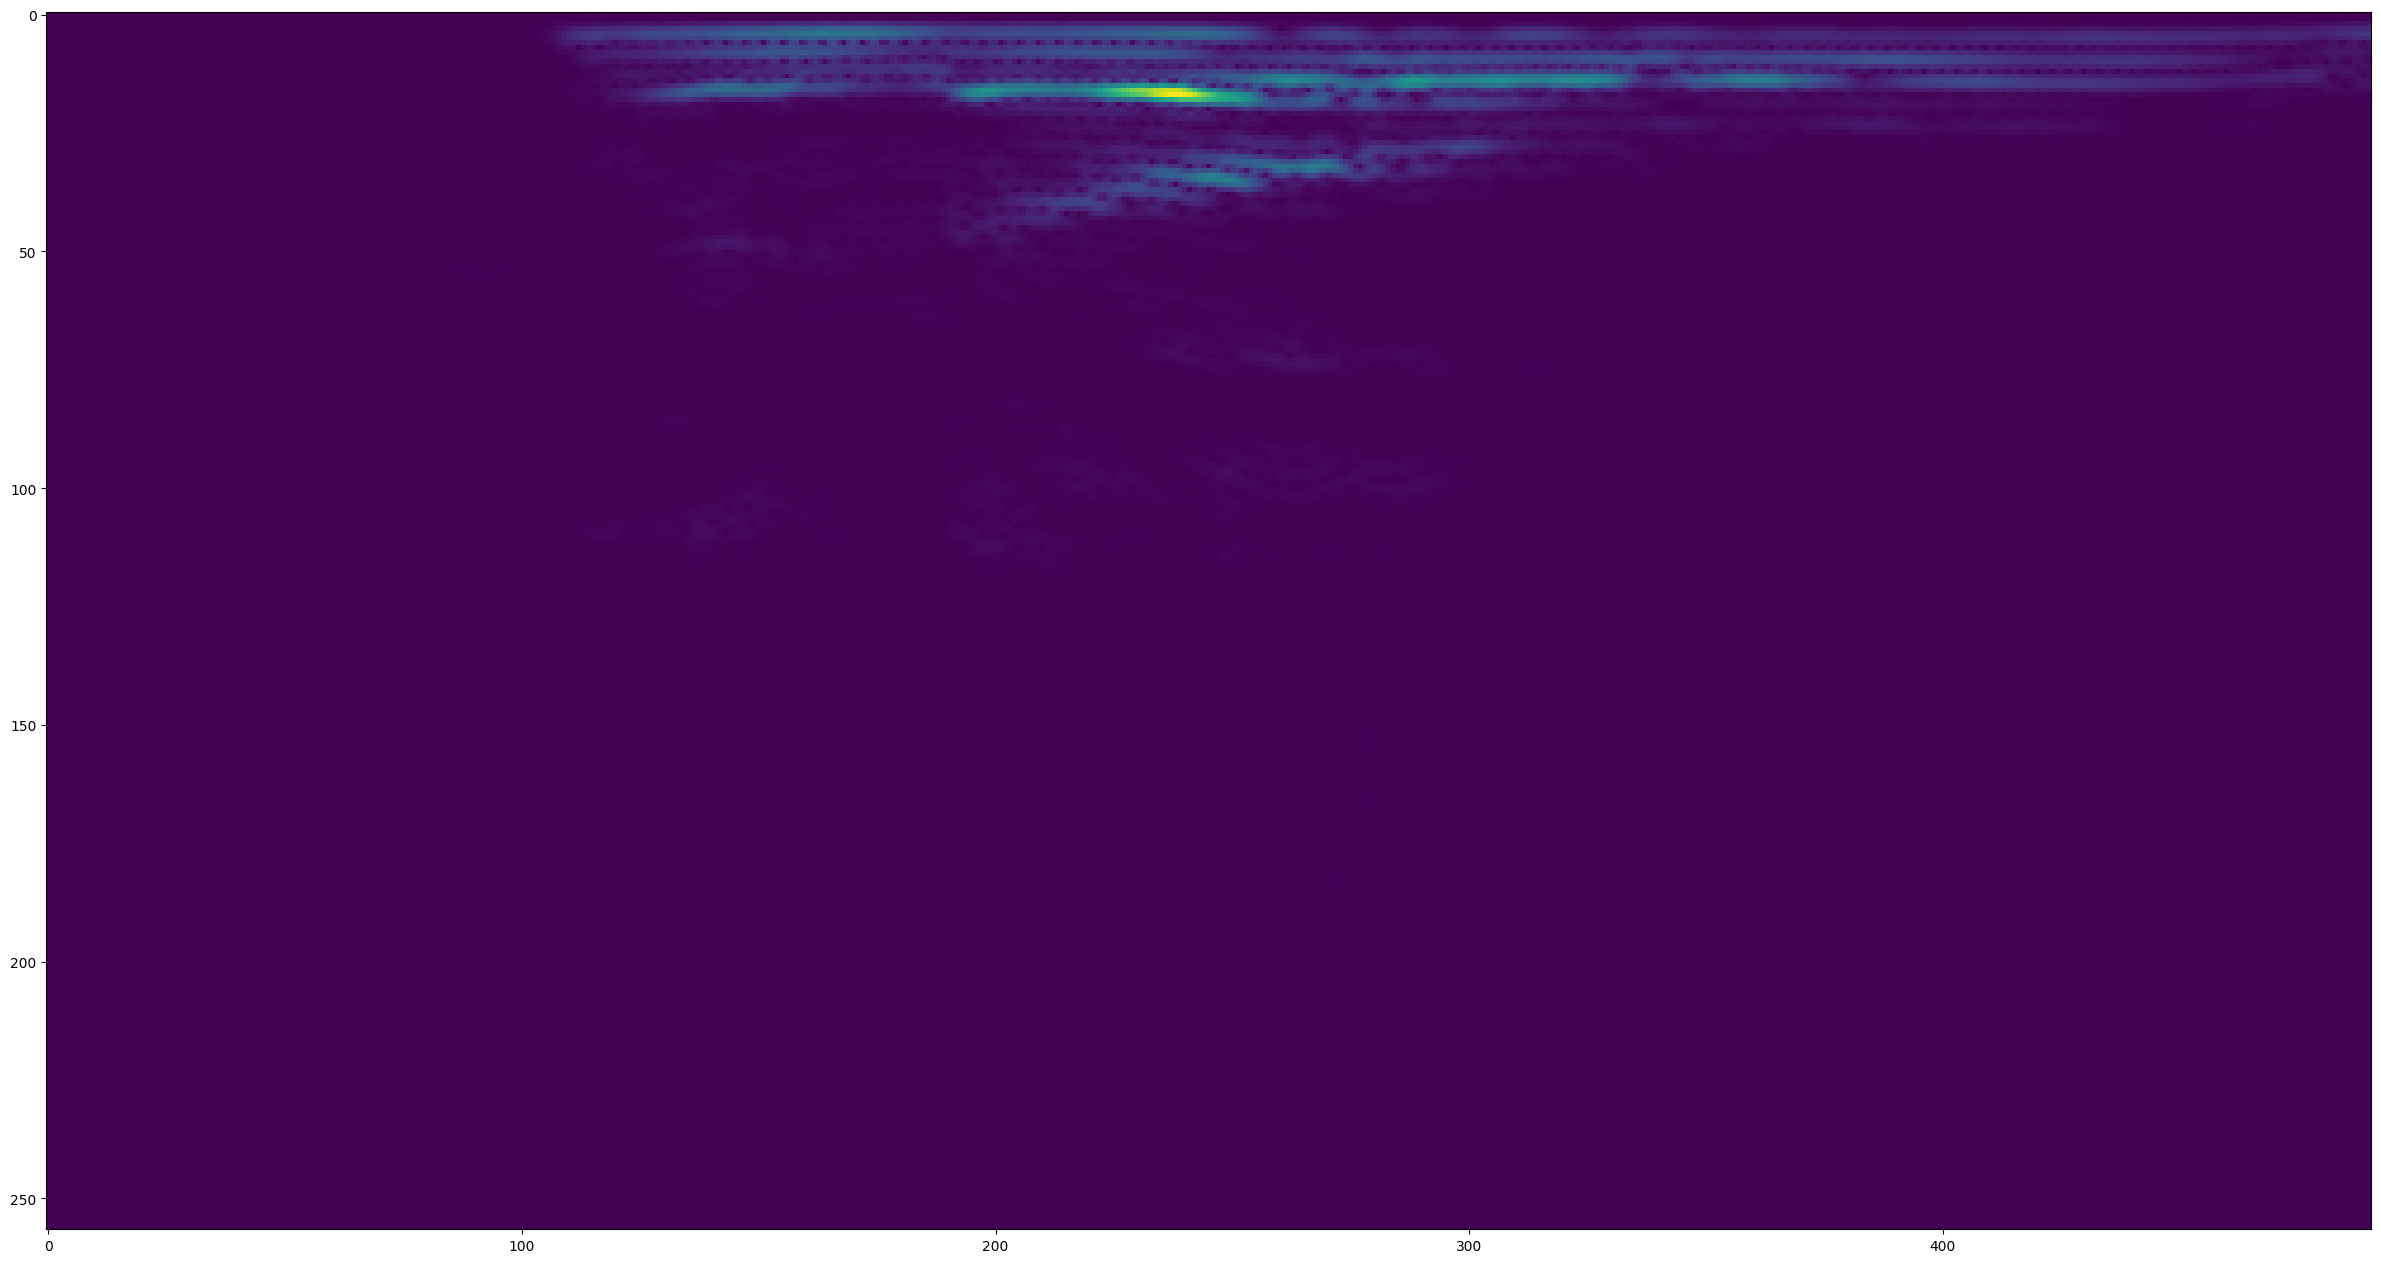

(491, 257)


In [ ]:
plt.figure(figsize= (30,20));
plt.imshow(tf.transpose(tf.squeeze(spect, axis=2)))
plt.show()

print(tf.squeeze(spect, axis=2).shape)

In [ ]:
mel_spectrogram = generate_mel_spectrogram(np.array(audio_pieces[0]), 16000)


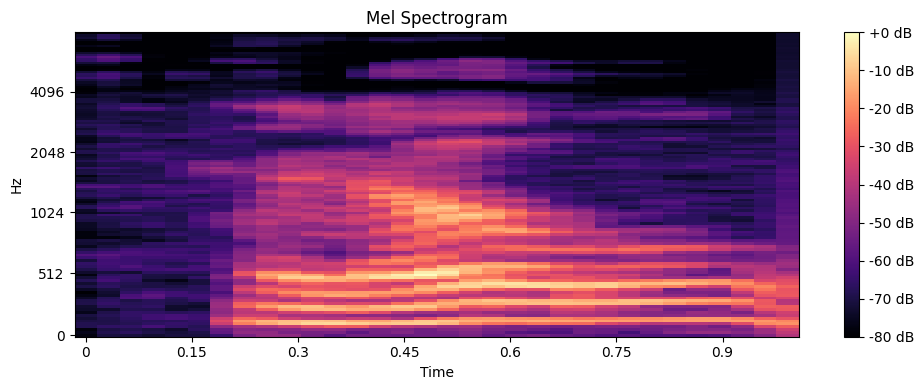

In [ ]:
disp_mel_spectrogram(mel_spectrogram)

In [ ]:
def process_wavs_to_spectorgrams_in_folder(folder_dir, isBackground):

  arrs = []
  count = 0;
  for file in os.listdir(folder_dir):
      tensor_wave = load_wav_16k_mono(folder_dir+ "/" + file)

      if(isBackground != True):
        tensor_wave = filter_silent_parts(tensor_wave)

      split = np.array(split_into_1sec_pieces(tensor_wave,16000))
      if(split.shape[0] != 0):
        arrs.append(split);

      count+= 1;
      if(count > 150):
        break;

  wavs = np.concatenate(arrs, axis=0);


  spectrograms = []
  for wav in wavs:
      spectrograms.append(generate_spectrogram(wav))

      # spectrograms.append(generate_mel_spectrogram(wav, sample_rate))
  return spectrograms;

In [ ]:
def process_data(root_folder_dir):
  folder_names = []  # Array to store the folder names

  # Iterate over all entries in the directory
  for entry in os.scandir(root_folder_dir):
      if entry.is_dir():  # Check if the entry is a directory
          folder_names.append(entry.name)  # Add the folder name to the array
  # print(folder_names)

  num_classes = len(folder_names);

  label_to_name_dict = {};
  spectrograms = [];
  labels = [];


  for i in range(len(folder_names)):
    dir = root_folder_dir  + folder_names[i];
    label_to_name_dict[i] = folder_names[i];

    spects = process_wavs_to_spectorgrams_in_folder(dir, folder_names[i] == "_background_noise_");
    spectrograms.append(spects);

    #Generate labels with one hot encoding
    labels.append(np.eye(num_classes)[np.full(len(spects), i).astype(int)]);
    # spectrograms = process_wavs_to_spectorgrams_in_folder(dir);

  spectrograms = np.concatenate(spectrograms)
  labels = np.concatenate(labels)

  return spectrograms, labels, label_to_name_dict

In [ ]:
def translate_one_hot_to_name(oneHotVector, label_to_name_dict):
    labels = np.argmax(oneHotVector, axis=1);
    names = [];
    for label in labels:
      names.append(label_to_name_dict[label]);
    return names;

In [ ]:
spectrograms, labels, label_to_name_dict = process_data(ROOT_FOLDER_DIR)


In [ ]:
label_to_name_dict

In [ ]:
print(spectrograms.shape)
print(labels.shape)

In [ ]:
data = tf.data.Dataset.zip(
    (tf.data.Dataset.from_tensor_slices(spectrograms), tf.data.Dataset.from_tensor_slices(labels)))

##Test Out the Function and Viz the Spectrogram


In [ ]:
spect, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
# disp_mel_spectrogram(spect)

In [ ]:
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = test.as_numpy_iterator().next()
samples.shape


#Build Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten,MaxPooling2D

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(491, 257, 1)))

# model.add(Conv2D(16, (3,3), activation='relu', input_shape=(128, 32,1)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dense(6, activation='softmax'))
model.add(Dense(8, activation='softmax'))

# model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()



In [ ]:
hist = model.fit(train, epochs=5, validation_data=test)


In [ ]:
stop

In [ ]:
#check if tensorflow is using gpu
tf.config.list_physical_devices('GPU')


In [ ]:
dir = ROOT + "models/"
dir

In [ ]:
model.save(dir + 'multi_speaker_with_the_breze')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model(dir + 'multi_speaker')

In [ ]:
loaded_model.summary()

In [ ]:
new_model = Sequential()
for layer in loaded_model.layers[:-1]:
    layer.trainable = False;
    new_model.add(layer)
new_model.add(Dense(7, activation='softmax'))  # New last layer

# Print the summary of the new model
new_model.summary()

In [ ]:
new_model.compile('Adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
hist = new_model.fit(train, epochs=5, validation_data=test)

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision_2'], 'r')
# plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall_2'], 'r')
# plt.plot(hist.history['val_recall'], 'b')
plt.show()

#Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
X_test[0].shape

In [ ]:
yhat = model.predict(X_test)

In [ ]:
translate_one_hot_to_name(yhat, label_to_name_dict)

In [ ]:
yhat = np.argmax(yhat, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
print(str(yhat));
print(str(y_test));

In [ ]:
def plot_audio_waveform(data, sample_rate):
    time = np.arange(0, len(data)) / sample_rate
    plt.plot(time, data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Audio Waveform')
    plt.show()

In [ ]:
def predict(audio_data):
    # spect = generate_mel_spectrogram(audio_data.flatten(), sample_rate)
    spect = generate_spectrogram(audio_data.flatten())
    yhat = loaded_model.predict(np.expand_dims(spect, axis=0))
    return translate_one_hot_to_name(yhat, label_to_name_dict)

In [ ]:
import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np

duration =8  # seconds
sample_rate = 16000  # Hz


audio_data = []

def callback(indata, frames, time, status):
    audio_data.append(indata.copy())
    print(predict(indata.copy()));



# Create an empty list to store the recorded audio data

# Create a stream with the specified parameters
stream = sd.InputStream(callback=callback, channels=1, samplerate=sample_rate, blocksize=sample_rate)

# Start the stream
stream.start()

# Wait for the specified duration
sd.sleep(int(duration * 1000))

# Stop the stream
stream.stop()


In [ ]:

# Concatenate the recorded audio data
audio_clip = np.concatenate(audio_data)

# Flatten the audio data for plotting
audio_clip = audio_clip.flatten()

# Plot audio waveform
plot_audio_waveform(audio_clip, sample_rate)

In [ ]:
Audio(audio_clip, rate=16000)

In [ ]:
audio_no_silence = filter_silent_parts(audio_clip)
# plot_audio_waveform(audio_no_silence, sample_rate)
split = np.array(split_into_1sec_pieces(audio_no_silence,16000))


spectrograms = []
for wav in audio_data:
    spectrograms.append(generate_spectrogram(wav.flatten()))


In [ ]:
spect = generate_spectrogram(audio_data[0].flatten())

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrograms[1])[0])
plt.show()


In [ ]:
X_test.shape
input_data = np.expand_dims(X_test[0], axis=0)
input_data.shape

In [ ]:
np.expand_dims(spect, axis=0).shape

In [ ]:
np.array(spectrograms).shape

In [ ]:
yhat = loaded_model.predict(np.array(spectrograms))
# yhat = loaded_model.predict(np.expand_dims(spect, axis=0))
translate_one_hot_to_name(yhat, label_to_name_dict)